In [1]:
import pandas as pd
from IPython.display import display
import re
import numpy as np
from IPython.display import Image
import folium
from folium import plugins
from collections import Counter
import requests
import json
from config import gkey
from pprint import pprint
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
results_df = pd.read_csv("Resources/Accidental_Drug_Related_Deaths_2012-2017_cleaned.csv")
Counter(results_df["Race"])

Counter({'White': 3242,
         'Hispanic, White': 432,
         'Black': 329,
         'Unknown': 16,
         'Asian, Other': 14,
         nan: 9,
         'Hispanic, Black': 17,
         'Other': 7,
         'Asian Indian': 9,
         'Chinese': 2,
         'Native American, Other': 1,
         'Hawaiian': 1})

In [3]:
results_df["Race"] = results_df["Race"].replace(['Unknown','Asian Indian','Chinese','Native American, Other', 'Hawaiian'],'Other')
results_df['Race'] = results_df['Race'].fillna('Other')

In [4]:
race_counts = Counter(results_df["Race"])
race_counts

Counter({'White': 3242,
         'Hispanic, White': 432,
         'Black': 329,
         'Other': 45,
         'Asian, Other': 14,
         'Hispanic, Black': 17})

In [5]:
sex_counts = Counter(results_df["Sex"])
sex_counts

Counter({'Male': 2992, 'Female': 1085, nan: 2})

In [6]:
results_df["Age"].describe()

count    4078.000000
mean       41.755763
std        12.318326
min        14.000000
25%        31.000000
50%        42.000000
75%        52.000000
max        87.000000
Name: Age, dtype: float64

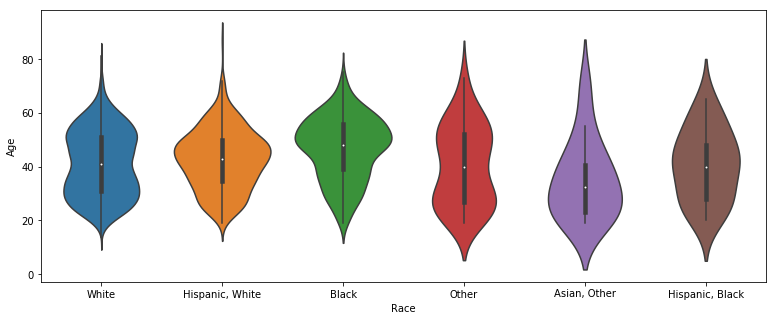

In [7]:
plt.figure(figsize=(13,5))
sns.violinplot(x="Race",y="Age",data=results_df)

plt.show()

In [8]:
age_groups = [0,20,30,40,50,60,70,80,120]
age_grp_names = ["<20","20-30","30-40","40-50","50-60","60-70","70-80",">80"]
results_df["Age Group"] = pd.cut(results_df["Age"],age_groups,labels=age_grp_names)

In [9]:
race_age_df = results_df.groupby(["Race","Age Group","Sex"])["CaseNumber"].count()
race_age_df

Race             Age Group  Sex   
Asian, Other     <20        Male        1
                 20-30      Male        6
                 30-40      Female      3
                 40-50      Female      2
                 50-60      Female      1
                 60-70      Male        1
Black            <20        Female      3
                            Male        2
                 20-30      Female      6
                            Male       28
                 30-40      Female     13
                            Male       49
                 40-50      Female     33
                            Male       60
                 50-60      Female     24
                            Male       76
                 60-70      Female      7
                            Male       24
                 70-80      Male        4
Hispanic, Black  <20        Female      1
                 20-30      Female      1
                            Male        3
                 30-40      Male        4

In [10]:
race_df = results_df.groupby("Race")["CaseNumber"].count()
race_order = race_df.sort_values(ascending=False).index

In [11]:
bars_male=[]
for race in race_order:
    age_bins = []
    for age_bin in race_age_df.index.levels[1]:
        try:
            age_bins.append(race_age_df[(race,age_bin,"Male")])
        except:
            age_bins.append(0)
    bars_male.append(age_bins)
bars_male

[[45, 540, 621, 528, 486, 113, 8, 0],
 [2, 51, 88, 134, 61, 13, 2, 1],
 [2, 28, 49, 60, 76, 24, 4, 0],
 [1, 10, 6, 5, 10, 1, 1, 0],
 [0, 3, 4, 2, 3, 1, 0, 0],
 [1, 6, 0, 0, 0, 1, 0, 0]]

In [12]:
bars_female=[]
for race in race_order:
    age_bins = []
    for age_bin in race_age_df.index.levels[1]:
        try:
            age_bins.append(race_age_df[(race,age_bin,"Female")])
        except:
            age_bins.append(0)
    bars_female.append(age_bins)
bars_female

[[21, 190, 190, 219, 231, 40, 8, 1],
 [0, 18, 15, 27, 14, 3, 1, 0],
 [3, 6, 13, 33, 24, 7, 0, 0],
 [1, 4, 1, 3, 2, 0, 0, 0],
 [1, 1, 0, 2, 0, 0, 0, 0],
 [0, 0, 3, 2, 1, 0, 0, 0]]

In [13]:
stacking_bars_male = []
stacking_bars_male.append(list(np.zeros(len(age_grp_names))))
for i in range(1,len(bars_male)):
    age_bar = np.zeros(len(age_grp_names))
    for j in range(0,i):
        age_bar += np.array(bars_male[j])
    stacking_bars_male.append(list(age_bar))
stacking_bars_male

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [45.0, 540.0, 621.0, 528.0, 486.0, 113.0, 8.0, 0.0],
 [47.0, 591.0, 709.0, 662.0, 547.0, 126.0, 10.0, 1.0],
 [49.0, 619.0, 758.0, 722.0, 623.0, 150.0, 14.0, 1.0],
 [50.0, 629.0, 764.0, 727.0, 633.0, 151.0, 15.0, 1.0],
 [50.0, 632.0, 768.0, 729.0, 636.0, 152.0, 15.0, 1.0]]

In [14]:
stacking_bars_female = []
stacking_bars_female.append(list(np.zeros(len(age_grp_names))))
for i in range(1,len(bars_female)):
    age_bar = np.zeros(len(age_grp_names))
    for j in range(0,i):
        age_bar += np.array(bars_female[j])
    stacking_bars_female.append(list(age_bar))
stacking_bars_female

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [21.0, 190.0, 190.0, 219.0, 231.0, 40.0, 8.0, 1.0],
 [21.0, 208.0, 205.0, 246.0, 245.0, 43.0, 9.0, 1.0],
 [24.0, 214.0, 218.0, 279.0, 269.0, 50.0, 9.0, 1.0],
 [25.0, 218.0, 219.0, 282.0, 271.0, 50.0, 9.0, 1.0],
 [26.0, 219.0, 219.0, 284.0, 271.0, 50.0, 9.0, 1.0]]

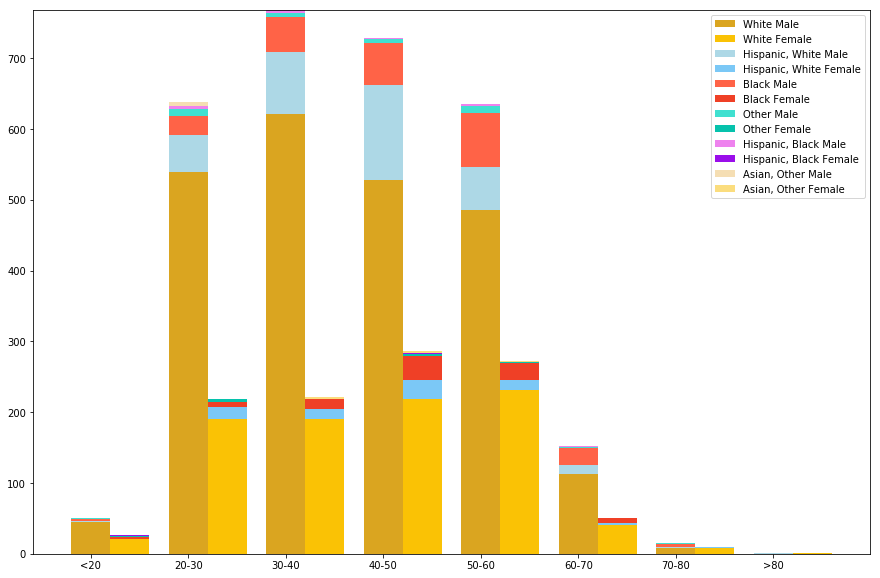

In [15]:
colors_list = ["goldenrod","lightblue","tomato","turquoise","violet","wheat", "sienna","plum","orchid"]

xticks = np.arange(1,len(age_groups))
plt.figure(figsize=(15,10))
w = 0.4
for i, race in enumerate(race_order):

    plt.bar(xticks,bars_male[i],bottom = stacking_bars_male[i],color=colors_list[i], label=race+" Male", width=w)
    plt.bar(xticks+w,bars_female[i],bottom = stacking_bars_female[i], color="xkcd:"+colors_list[i],\
            label=race+" Female", width=w)

plt.xticks(xticks, age_grp_names)
plt.legend()
plt.show()